
## ✅ Summary of the Task

**Goal**: Given a sequence of discrete 6D word vectors (representing an unknown language), predict whether the **next word will increase or decrease the sentiment** of the sentence.

---

## 🧱 Step-by-Step Plan

### 1. **Synthetic Dataset Creation**

* Build a vocabulary of discrete 6D word vectors.
* Define a simple but meaningful **sentiment function** over sequences (e.g., a non-linear function of vector mean or weighted sum).
* For each sequence, compute sentiment before and after adding the next word → label: `↑` or `↓`.

### 2. **Input Preprocessing**

Since vectors are discrete:

* Normalize: ✅ (to remove scale issues).
* Quantize: ❌ probably not needed unless you're feeding integer tokens. Transformers work better with continuous embeddings.

So: **normalize the vectors (e.g., MinMax or z-score)**, but don’t quantize yet — we’re not tokenizing.

### 3. **Model Architecture**

* Transformer encoder for the **sequence** of vectors.
* Final vector (to be predicted) can be:

  * Appended (and let the model learn the delta)
  * OR input separately and compared with sentence encoding

**Output**: Binary classification (↑ or ↓ in sentiment)

---


In [2]:
import jupyter

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt


from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker

In [42]:
ohlcv_df = OHLCV_DF[OHLCV_DF['symbol']=="TSLA"].copy()


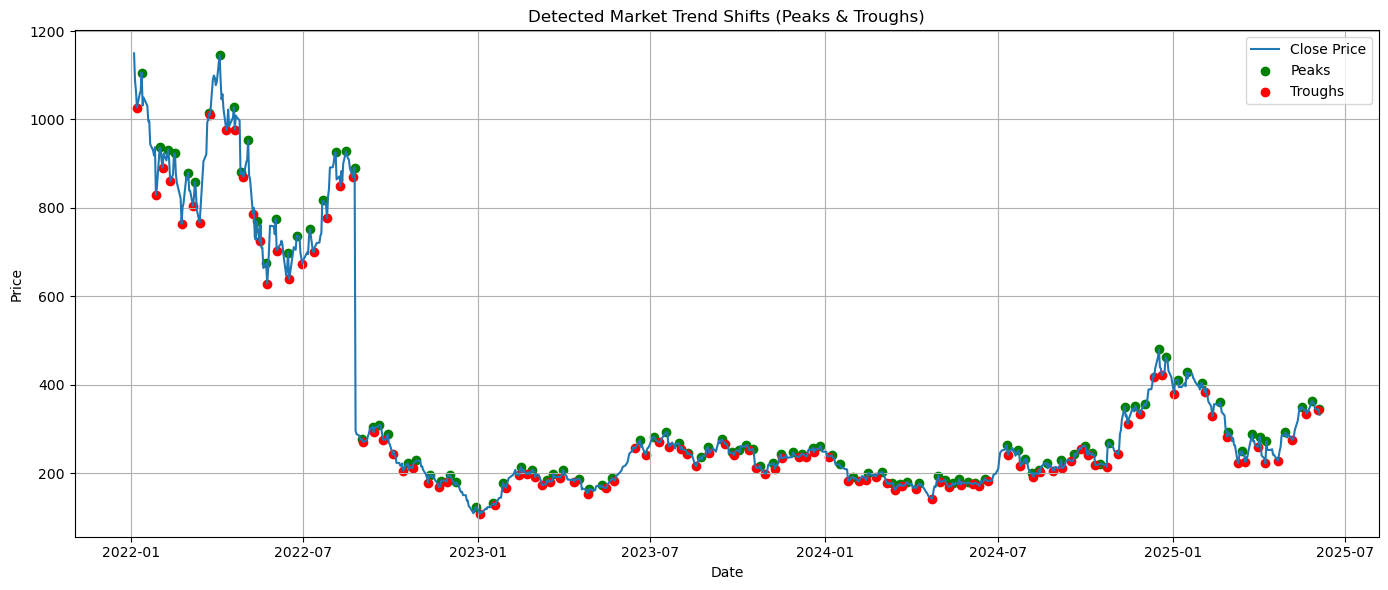

In [43]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import ruptures as rpt
import matplotlib.pyplot as plt

# Detect peaks and troughs in the price
price_series = ohlcv_df['close']
peaks, _ = find_peaks(price_series, distance=5, prominence=1)
troughs, _ = find_peaks(-price_series, distance=5, prominence=1)

# Combine into shift points
shift_points = np.sort(np.concatenate([peaks, troughs]))

# Visualize
plt.figure(figsize=(14, 6))
plt.plot(ohlcv_df['date'], price_series, label='Close Price', linewidth=1.5)
plt.scatter(ohlcv_df['date'].iloc[peaks], price_series.iloc[peaks], color='green', label='Peaks')
plt.scatter(ohlcv_df['date'].iloc[troughs], price_series.iloc[troughs], color='red', label='Troughs')
plt.title("Detected Market Trend Shifts (Peaks & Troughs)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:

from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
import pywt

In [45]:

# Window around each shift point to extract features (e.g., last 20 days)
lookback = 128

def wavelet_entropy(signal, wavelet='db4'):
    coeffs = pywt.wavedec(signal, wavelet)
    energy = np.array([np.sum(np.square(c)) for c in coeffs])
    energy /= energy.sum()
    entropy = -np.sum(energy * np.log2(energy + 1e-8))  # Add epsilon to avoid log(0)
    return entropy

# Prepare feature rows
feature_rows = []

for shift_idx in shift_points:
    if shift_idx < lookback:
        continue
    window = ohlcv_df.iloc[shift_idx - lookback:shift_idx]
    prices = window['close'].values
    volume = window['volume'].values

    returns = np.diff(prices) / prices[:-1]

    try:
        adf_p = adfuller(prices)[1]
    except:
        adf_p = np.nan

    try:

        hurst_exp, _, _ = compute_Hc(prices, simplified=True)
    except Exception as e:
        print(e)
        hurst_exp = np.nan

    row = {
        "date": ohlcv_df.iloc[shift_idx]["date"],
        "price_mean": np.mean(prices),
        "price_std": np.std(prices),
        "price_skew": skew(prices),
        "price_kurt": kurtosis(prices),
        "return_std": np.std(returns),
        "return_mean": np.mean(returns),
        "volume_mean": np.mean(volume),
        "volume_std": np.std(volume),
        "adf_pvalue": adf_p,
        "hurst": hurst_exp,
        "wavelet_entropy": wavelet_entropy(prices),
        "shift_label": 1  # All these rows are around actual shifts
    }
    feature_rows.append(row)

import pandas as pd
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Trend Shift Feature Set", dataframe=pd.DataFrame(feature_rows))


Trend Shift Feature Set


Loading ITables v2.4.0 from the internet... (need help?)


In [46]:
# Now for non shift points
# Step: Create negative samples (non-shift points)
all_indices = set(range(lookback, len(ohlcv_df)))
non_shift_indices = list(all_indices - set(shift_points))

# Sample an equal number of non-shift points for balanced training
np.random.seed(42)
negative_sample_indices = np.random.choice(non_shift_indices, size=len(feature_rows), replace=False)

# Extract features for negative (non-shift) points
negative_feature_rows = []

for idx in negative_sample_indices:
    window = ohlcv_df.iloc[idx - lookback:idx]
    prices = window['close'].values
    volume = window['volume'].values

    returns = np.diff(prices) / prices[:-1]

    try:
        adf_p = adfuller(prices)[1]
    except:
        adf_p = np.nan

    row = {
        "date": ohlcv_df.iloc[idx]["date"],
        "price_mean": np.mean(prices),
        "price_std": np.std(prices),
        "price_skew": skew(prices),
        "price_kurt": kurtosis(prices),
        "return_std": np.std(returns),
        "return_mean": np.mean(returns),
        "volume_mean": np.mean(volume),
        "volume_std": np.std(volume),
        "adf_pvalue": adf_p,
        "wavelet_entropy": wavelet_entropy(prices),
        "shift_label": 0
    }
    negative_feature_rows.append(row)

# Merge positive and negative examples
all_rows = feature_rows + negative_feature_rows
full_feature_df = pd.DataFrame(all_rows)


# Define a new label where a shift occurs in the *next 5 days*
# We assume `shift_points` still holds the list of detected shift indices

# First, map shift dates to indices
shift_dates = set(ohlcv_df.iloc[shift_points]['date'])

# Build a date → label map using a lookahead of 5 days
lookahead = 5
date_list = list(full_feature_df['date'])

new_labels = []
for i, current_date in enumerate(date_list):
    future_dates = date_list[i + 1:i + lookahead + 1]
    label = int(any(future_date in shift_dates for future_date in future_dates))
    new_labels.append(label)

# Update the DataFrame
full_feature_df['shift_label'] = new_labels

# Recheck label distribution
label_counts = full_feature_df['shift_label'].value_counts().to_dict()


tools.display_dataframe_to_user(name="Trend Shift Training Set", dataframe=full_feature_df)
label_counts


Trend Shift Training Set


Loading ITables v2.4.0 from the internet... (need help?)


{0: 180, 1: 178}

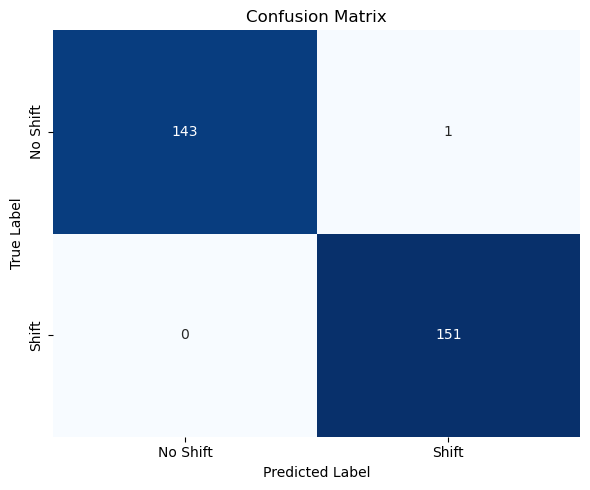

<Figure size 600x500 with 0 Axes>

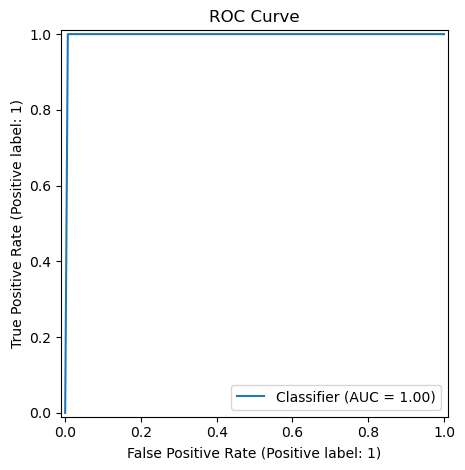

{'classification_report': {'0': {'precision': 1.0,
   'recall': 0.9930555555555556,
   'f1-score': 0.9965156794425087,
   'support': 144.0},
  '1': {'precision': 0.993421052631579,
   'recall': 1.0,
   'f1-score': 0.9966996699669967,
   'support': 151.0},
  'accuracy': 0.9966101694915255,
  'macro avg': {'precision': 0.9967105263157895,
   'recall': 0.9965277777777778,
   'f1-score': 0.9966076747047528,
   'support': 295.0},
  'weighted avg': {'precision': 0.9966324710080287,
   'recall': 0.9966101694915255,
   'f1-score': 0.9966098576431788,
   'support': 295.0}},
 'confusion_matrix': [[143, 1], [0, 151]],
 'roc_auc_score': 0.9965277777777778}

In [59]:
# Classify
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# Sort by date to preserve time order and prevent future peeking
full_feature_df = full_feature_df.sort_values("date").reset_index(drop=True)

# Separate features and labels
feature_cols = [col for col in full_feature_df.columns if col not in ['date', 'shift_label']]
X = full_feature_df[feature_cols].values
y = full_feature_df['shift_label'].values

# Use TimeSeriesSplit to avoid data leakage
tscv = TimeSeriesSplit(n_splits=5)
y_true, y_pred = [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale features using StandardScaler (AutoScaler alternative)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_scaled, y_train)

    # Predict and collect results
    y_pred.extend(clf.predict(X_test_scaled))
    y_true.extend(y_test)

# Evaluation metrics
report = classification_report(y_true, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay

# Confusion matrix visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ["No Shift", "Shift"])
plt.yticks([0.5, 1.5], ["No Shift", "Shift"])
plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_true, y_pred)
plt.title("ROC Curve")
plt.tight_layout()
plt.show()


{
    "classification_report": report,
    "confusion_matrix": conf_matrix.tolist(),
    "roc_auc_score": roc_auc
}


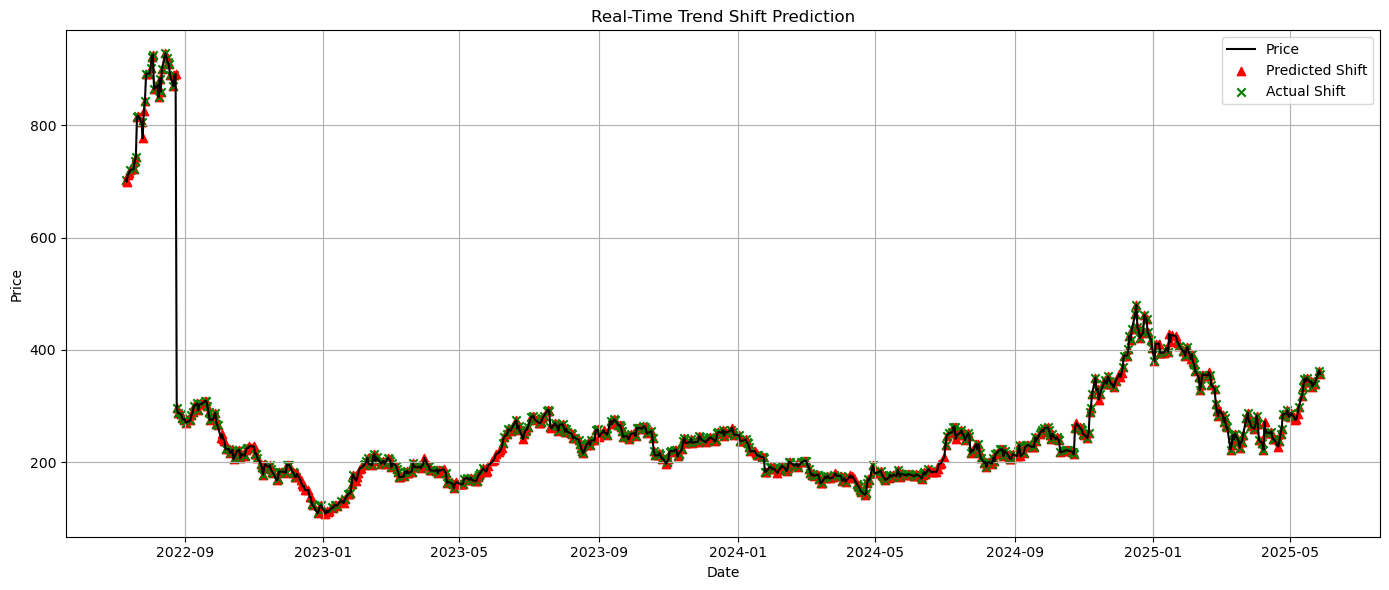

In [56]:
# CONFIRMAÇÃO - REAL TIME SIMULATION
# Set up the real-time simulation loop
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

lookback = 128
lookahead = 5

# Prepare the trained model on full dataset first
feature_cols = [col for col in full_feature_df.columns if col not in ['date', 'shift_label']]
X_full = full_feature_df[feature_cols].values
y_full = full_feature_df['shift_label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_scaled, y_full)

# Run real-time loop on unseen part of the data
dates = []
prices = []
alerts = []
actual_shifts = []

price_series = ohlcv_df['close'].values
dates_series = ohlcv_df['date'].values
shift_set = set(shift_points)

for i in range(lookback, len(ohlcv_df) - lookahead):
    window = ohlcv_df.iloc[i - lookback:i]
    current_date = ohlcv_df.iloc[i]['date']
    current_price = ohlcv_df.iloc[i]['close']
    prices.append(current_price)
    dates.append(current_date)

    # Compute features
    prices_w = window['close'].values
    volume = window['volume'].values
    returns = np.diff(prices_w) / prices_w[:-1]

    try:
        adf_p = adfuller(prices_w)[1]
    except:
        adf_p = np.nan
    try:
        hurst_exp, _, _ = compute_Hc(prices_w, simplified=True)
    except:
        hurst_exp = np.nan

    row = np.array([
        np.mean(prices_w),
        np.std(prices_w),
        skew(prices_w),
        kurtosis(prices_w),
        np.std(returns),
        np.mean(returns),
        np.mean(volume),
        np.std(volume),
        adf_p,
        hurst_exp,
        wavelet_entropy(prices_w)
    ]).reshape(1, -1)

    row_scaled = scaler.transform(row)
    prob = clf.predict_proba(row_scaled)[0, 1]
    alerts.append(prob > 0.3)

    # Ground truth: did a shift occur in next 5 days?
    actual_shift = any((i + j) in shift_set for j in range(1, lookahead + 1))
    actual_shifts.append(actual_shift)

# Plot real-time predictions vs. actual shifts
plt.figure(figsize=(14, 6))
plt.plot(dates, prices, label="Price", color="black")

for j, (dt, price, alert, actual) in enumerate(zip(dates, prices, alerts, actual_shifts)):
    if alert:
        plt.scatter(dt, price, color="red", label="Predicted Shift" if j == 0 else "", marker="^")
    if actual:
        plt.scatter(dt, price, color="green", label="Actual Shift" if j == 0 else "", marker="x")

plt.title("Real-Time Trend Shift Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert boolean to integers for comparison
alerts_binary = np.array(alerts).astype(int)
actuals_binary = np.array(actual_shifts).astype(int)

# Basic classification metrics
precision = precision_score(actuals_binary, alerts_binary)
recall = recall_score(actuals_binary, alerts_binary)
f1 = f1_score(actuals_binary, alerts_binary)

# Find lead times for true positives
lead_times = []
for i in range(len(alerts_binary)):
    if alerts_binary[i]:
        for offset in range(1, lookahead + 1):
            if i + offset < len(actuals_binary) and (i + offset) in shift_set:
                lead_times.append(offset)
                break

# Calculate average lead time
average_lead_time = np.mean(lead_times) if lead_times else None

# Additional stats
false_positives = np.sum((alerts_binary == 1) & (actuals_binary == 0))
false_negatives = np.sum((alerts_binary == 0) & (actuals_binary == 1))
true_positives = np.sum((alerts_binary == 1) & (actuals_binary == 1))
true_negatives = np.sum((alerts_binary == 0) & (actuals_binary == 0))

{
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "average_lead_time_days": average_lead_time,
    "true_positives": int(true_positives),
    "false_positives": int(false_positives),
    "false_negatives": int(false_negatives),
    "true_negatives": int(true_negatives)
}


{'precision': 0.8549723756906077,
 'recall': 1.0,
 'f1_score': 0.9218168279970216,
 'average_lead_time_days': 2.504823151125402,
 'true_positives': 619,
 'false_positives': 105,
 'false_negatives': 0,
 'true_negatives': 0}

In [64]:


# Rebuild full timeline evaluation — from lookback to len - lookahead
evaluation_start = lookback
evaluation_end = len(ohlcv_df) - lookahead

dates_eval = []
prices_eval = []
alerts_eval = []
actuals_eval = []
probs_eval = []

for i in range(evaluation_start, evaluation_end):
    window = ohlcv_df.iloc[i - lookback:i]
    current_date = ohlcv_df.iloc[i]["date"]
    current_price = ohlcv_df.iloc[i]["close"]
    prices_eval.append(current_price)
    dates_eval.append(current_date)

    prices_w = window["close"].values
    volume = window["volume"].values
    returns = np.diff(prices_w) / prices_w[:-1]

    try:
        adf_p = adfuller(prices_w)[1]
    except:
        adf_p = np.nan
    try:
        hurst_exp, _, _ = compute_Hc(prices_w, simplified=True)
    except:
        hurst_exp = np.nan
    """
    features = np.array([
        np.mean(prices_w),
        np.std(prices_w),
        skew(prices_w),
        kurtosis(prices_w),
        np.std(returns),
        np.mean(returns),
        np.mean(volume),
        np.std(volume),
        adf_p,
        wavelet_entropy(prices_w)
    ]).reshape(1, -1)
    """
    features = np.array([
        np.mean(prices_w),
        np.std(prices_w),
        skew(prices_w),
        kurtosis(prices_w),
        np.std(returns),
        np.mean(returns),
        np.mean(volume),
        np.std(volume),
        adf_p,
        hurst_exp,
        wavelet_entropy(prices_w)
    ]).reshape(1, -1)

    # Match training features (no hurst used in training)
    features_scaled = scaler.transform(features)

    prob = clf.predict_proba(features_scaled)[0, 1]
    probs_eval.append(prob)

    alert = prob > 0.3  # use adjusted threshold
    alerts_eval.append(int(alert))

    # Label: is a shift happening in next 5 days?
    future_dates = ohlcv_df.iloc[i+1:i+lookahead+1]["date"]
    actual = int(any(d in shift_dates_set for d in future_dates))
    actuals_eval.append(actual)

# Now compute full classification metrics
alerts_binary = np.array(alerts_eval)
actuals_binary = np.array(actuals_eval)

precision = precision_score(actuals_binary, alerts_binary, zero_division=0)
recall = recall_score(actuals_binary, alerts_binary, zero_division=0)
f1 = f1_score(actuals_binary, alerts_binary, zero_division=0)

lead_times = []
for i in range(len(alerts_binary)):
    if alerts_binary[i]:
        for offset in range(1, lookahead + 1):
            if i + offset < len(actuals_binary) and dates_eval[i + offset] in shift_dates_set:
                lead_times.append(offset)
                break

average_lead_time = np.mean(lead_times) if lead_times else None

true_positives = np.sum((alerts_binary == 1) & (actuals_binary == 1))
false_positives = np.sum((alerts_binary == 1) & (actuals_binary == 0))
false_negatives = np.sum((alerts_binary == 0) & (actuals_binary == 1))
true_negatives = np.sum((alerts_binary == 0) & (actuals_binary == 0))

{
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "average_lead_time_days": average_lead_time,
    "true_positives": int(true_positives),
    "false_positives": int(false_positives),
    "false_negatives": int(false_negatives),
    "true_negatives": int(true_negatives)
}


NameError: name 'shift_dates_set' is not defined

In [62]:
X.shape

(358, 11)